# Procena kvaliteta crnog vina portugalske kompanije  "Vinho Verde" 

Izvor podataka: https://archive.ics.uci.edu/ml/datasets/Wine+Quality



### * Cilj obrde podataka:
Odrediti kojoj je kvalitet vina. (Kategorije vina prikazane su ocenama od 0-vrlo loše, do 10-vrlo dobro) 
### * Analiza skupa:
Dostupni su samo fizičko-hemijske i promenljive dobijene od senzora. Nema podataka o vrstama grožđa, marki vina i prodajnoj ceni.
Ulazni parametri uključuju objektivne testove, a izlazn se zanisvaju na senzornim podacima. 
Nekoliko atributa moze biti u korelaciji, pa ima smisla primeniti neku vrstu izbora karakteristika.


** Neki atributi mogu biti u korelaciji, pa je potrebno izvrsiti izbor karakteristika.

Zadaci pogodni za klasifikacije i regresije. Klase su proređene i nisu uravnotžene (Ima više normalnih vina nego odličnih ili loših). 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## Ucitavanje podataka

In [2]:
vina = pd.read_csv("datasets/winequality-red.csv", sep=',', skip_blank_lines=True)
vina.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,x,x2
0,7.4,0.70,0.00,1.9,76.0,11.0,34.0,0.9978,3.51,0.56,9.4,5,"0,11","0,34"
1,7.8,0.88,0.00,2.6,98.0,25.0,67.0,0.9968,3.20,0.68,9.8,5,"0,25","0,67"
2,7.8,0.76,0.04,2.3,92.0,15.0,54.0,997.0000,3.26,0.65,9.8,5,"0,15","0,54"
3,11.2,0.28,0.56,1.9,75.0,17.0,60.0,998.0000,3.16,0.58,9.8,6,"0,17","0,6"
4,7.4,0.70,0.00,1.9,76.0,11.0,34.0,0.9978,3.51,0.56,9.4,5,"0,11","0,34"


In [3]:
vina.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,84.830550,0.270976,2.538806,77.470294,15.874922,46.467792,58.321478,3.311113,0.658149,10.422983,5.636023
std,1.741096,234.417251,0.194801,1.409928,51.628973,10.460157,32.895324,232.081972,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.050000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.400000,0.090000,1.900000,65.000000,7.000000,22.000000,0.995640,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,77.000000,14.000000,38.000000,0.996800,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.660000,0.420000,2.600000,88.000000,21.000000,62.000000,0.998160,3.400000,0.730000,11.100000,6.000000
max,15.900000,1185.000000,1.000000,15.500000,611.000000,72.000000,289.000000,1001.000000,4.010000,2.000000,14.900000,8.000000


# Normalizacija podataka

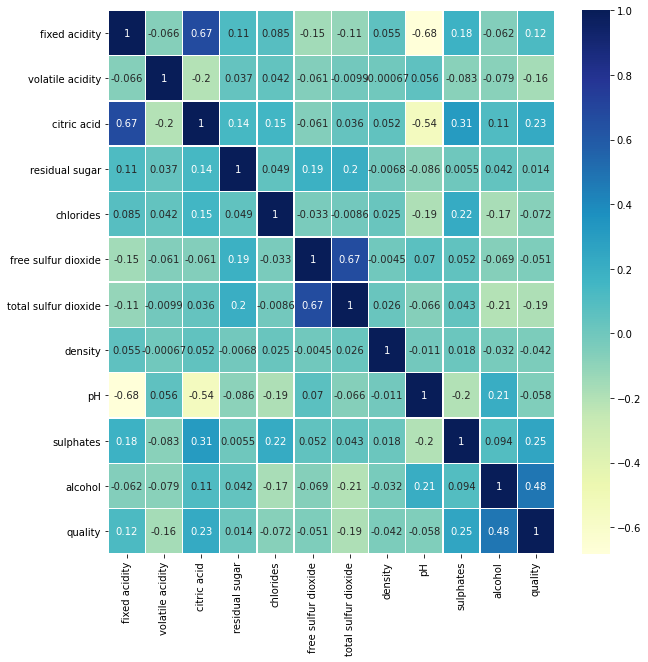

In [4]:
# matrica korelacija jer u podacima postoje velika odstupanje
# Prikaz zavisnosti preko Pearsonove korelacije

matrica = vina.corr()

#sns.heatmap(matrica,cmap="YlGnBu")
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(matrica,cmap="YlGnBu", annot=True, linewidths=.5, ax = ax)

## Linearna regresija

Ja cu prvo koristiti model linearne regrresije da utvrdim kvalitet vina.
Preporuceno je koristiti metodu elimacije unazad
Kroz sledece korake:
1. selektovanje znacajne nivo da bi ostao u modelu (pr: SL = 0.05)
2. prilagoditi model za sva moguca pogadjanja
3. razmatramo pogadjanje sa najvecom P vrednoscu, if P > SL then go to STEP 4 or else to STEP 6
4. ukloniti predvidjanje
5. prilagodi model bez ove promenljie i vrati se na korak 3
6. Kraj

In [5]:
# uklanjanje promenljive iz podataka
lin_skup_podataka = vina.drop(['fixed acidity','density','citric acid','free sulfur dioxide','total sulfur dioxide'],axis = 1,inplace=False)

x_vrednosti = lin_skup_podataka.loc[:,'volatile acidity' : 'alcohol'].values
y = lin_skup_podataka.loc[:, 'quality'].values

In [6]:
# eliminacija unazad
x_opt = x_vrednosti[:,0:6]

# podea na test i trening
x_train,x_test,y_train,y_test = train_test_split(x_opt,y,test_size = 0.2)

# skaliranje karakteristia
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

# primena Linearn regresija
regressor = LinearRegression()
regressor.fit(x_train,y_train)


y_pred = regressor.predict(x_test)

# izracunavaanje vrednostti greske da vidimo koliko dobro model predvidja
greska = sqrt(mean_squared_error(y_test, y_pred))
print("Greska:" , greska)

Greska: 0.6715994801507426


# Klasifikacija

In [7]:
#Normalization ==> x_norm = (x - mean)/std 
#it gives for each value the same value intervals means between 0-1
def normalization(x_vrednosti):
    mean = np.mean(x_vrednosti)
    std = np.std(x_vrednosti)
    x_t = (x_vrednosti - mean)/std
    return x_t

### Logisticka regresija
Logisticka regresija je analiza skupa podataka u kome postoji jedna ili vise nezavisnih promenljivih koje odredjuju rezultat. Koristi kada su u pitanju varijable čije su vrednosti kontinualne ili metričke. Koristi se da se predvidi binani rezultat(1 / 0, Yes / No, True / False) s obziron na skup nezvisnih promenljivih. Logisticka regresija je algoritam klasifikacije. 

Za ovaj skup podataka trebalo bi prvo koristiti oridinalnu logisticku regresiju a nakon toga bolje je koristiti binarnu logisticku regresiju sa modifikovanim podacima. Formula logisticke regresije: P= 1/(1+ e^(-(b_0+ b_1 x)) )


In [8]:
#Normalization
x_t = normalization(x_vrednosti)
y = vina['quality']

#Train and Test splitting of data 
x_train, x_test, y_train, y_test = train_test_split(x_t, y, test_size = 0.2)

#X_t
#plt.scatter(X_t[:,1], X_t[:,5], c = y)


Greska: 0.515625


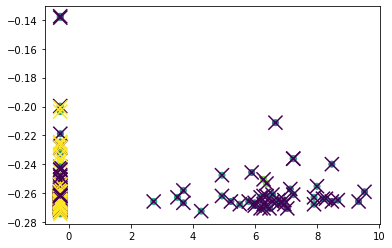

In [9]:
log_red = LogisticRegression(max_iter = 30000)
log_red.fit(x_train, y_train)
print("Greska:", log_red.score(x_test, y_test)) # Tacnost modela

plt.scatter(x_test[:,0], x_test[:,1], c=y_test)
plt.scatter(x_test[:,0], x_test[:,1], c=log_red.predict(x_test), marker="x", s = 200)


### Perceptron

Perceptron je algoritam za nadgledano ucenje binarnih klasifikatora. Binarni klasifikator je funkcija koja odlucuje da li ulaz predstavljen vektorom brojeva pripada istoj odredjenoj klasi. To je vrsta linearnog klasifikatora. Predvidjanja zasniva na lineanoj funkciji prediktora kombinjuci skup sa vektorom karakteristika.

Greska:  0.365625


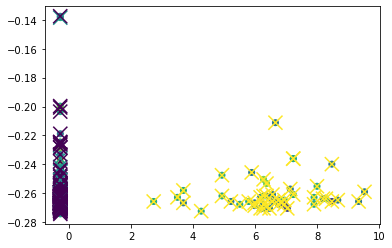

In [10]:
# Perceptron
clf = Perceptron(max_iter = 30000)
clf.fit(x_train, y_train)
print("Greska: ",  clf.score(x_test, y_test)) # Tacnost modela

plt.scatter(x_test[:,0], x_test[:,1], c=y_test)
plt.scatter(x_test[:,0], x_test[:,1], c=clf.predict(x_test), marker="x", s = 200)

### Stohastic gradient descent (SGD)

Stochastic gradient descent (SGD) je iterativna metoda za optimizaciju funkcije objekata sa odgovarajucim svojstvima (npr. difirencijalni ili subdiferencijalni

Greska:  0.5261923377638781


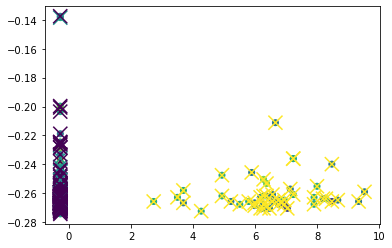

In [11]:
sgd = make_pipeline(StandardScaler(), SGDClassifier(max_iter=30000, tol=1e-3))
sgd.fit(x_train, y_train)
print("Greska: " , sgd.score(x_train, y_train))

plt.scatter(x_test[:,0], x_test[:,1], c=y_test)
plt.scatter(x_test[:,0], x_test[:,1], c=clf.predict(x_test), marker="x", s = 200)

# ZAKLJUČAK

* Linearna regresija oko 68%
* Logisticka regresija 48%
* Perceptron 47%
* SGD 45%